<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Image_Classification/MNIST/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Classification

* Problem statement: Classify hand-written digits into their respective classes.
* Dataset to be used: keras.datasets.mnist

# Connect to Google Drive

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, Model
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.schedules import InverseTimeDecay 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import apply_affine_transform

from sklearn.model_selection import train_test_split

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

# Define directory paths

In [3]:
# Define base path for TensorBoard Logs directory
tb_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/TB_Logs/"
os.makedirs(tb_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_Classification/Training_Outputs/"
os.makedirs(out_base_path, exist_ok = True) # Don't raise any exception if directory exists

# Dataset - Import, EDA and pre-process

## Import dataset

In [4]:
# Download MNIST dataset
(X_train, y_train), (X_test_orig, y_test_orig) = mnist.load_data()
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_test is {X_test_orig.shape}")

11493376/11490434 [==============================] - 0s 0us/step
Shape of X_train is (60000, 28, 28)
Shape of X_test is (10000, 28, 28)


## Split test set into test and validation sets

In [5]:
# Split test set into test and validation sets
num_val_samp = 1000 # Number of validation set samples to generate
X_test, X_val, y_test, y_val = train_test_split(X_test_orig, y_test_orig,\
                                                test_size = num_val_samp, random_state = 1234)

## Get information about train, val and test datasets

In [6]:
print("Training_Set_Information:")
print("-------------------------")
print("Shape of training set data input is {}" .format(X_train.shape))
print("Number of training data samples is %d" %(X_train.shape[0]))
print("Shape of each training set sample is {}" .format(X_train.shape[1:3]))
print("Shape of training set output is {}" .format(y_train.shape))
print()
print("Validation_Set_Information:")
print("---------------------------")
print("Shape of validation set data input is {}" .format(X_val.shape))
print("Number of validation data samples is %d" %(X_val.shape[0]))
print("Shape of each validation set sample is {}" .format(X_val.shape[1:3]))
print("Shape of validation set output is {}" .format(y_val.shape))
print()
print("Test_Set_Information:")
print("--------------------:")
print("Shape of test set data input is {}" .format(X_test.shape))
print("Number of test data samples is %d" %(X_test.shape[0]))
print("Shape of each test set sample is {}" .format(X_test.shape[1:3]))
print("Shape of test set output is {}" .format(y_test.shape))

Training_Set_Information:
-------------------------
Shape of training set data input is (60000, 28, 28)
Number of training data samples is 60000
Shape of each training set sample is (28, 28)
Shape of training set output is (60000,)

Validation_Set_Information:
---------------------------
Shape of validation set data input is (1000, 28, 28)
Number of validation data samples is 1000
Shape of each validation set sample is (28, 28)
Shape of validation set output is (1000,)

Test_Set_Information:
--------------------:
Shape of test set data input is (9000, 28, 28)
Number of test data samples is 9000
Shape of each test set sample is (28, 28)
Shape of test set output is (9000,)


In [7]:
print("Minimum value of training data samples is %d" %(X_train.min()))
print("Maximum value of training data samples is %d" %(X_train.max()))
print()
print("Minimum value of validation data samples is %d" %(X_val.min()))
print("Maximum value of validation data samples is %d" %(X_val.max()))
print()
print("Minimum value of test data samples is %d" %(X_test.min()))
print("Maximum value of training data samples is %d" %(X_test.max()))
print()

Minimum value of training data samples is 0
Maximum value of training data samples is 255

Minimum value of validation data samples is 0
Maximum value of validation data samples is 255

Minimum value of test data samples is 0
Maximum value of training data samples is 255



<b>Above data indicates that the images are encoded as 28 x 28 grayscale images encoded in 0 to 255 integer format.</b>

## Get class distribution

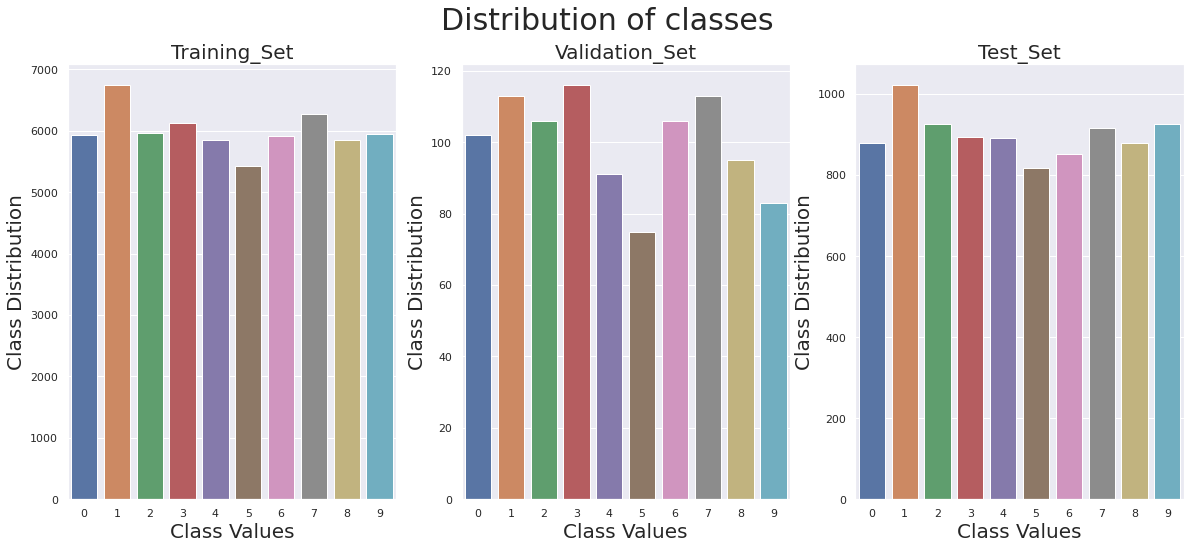

In [8]:
sns.set(color_codes = True)
fig = plt.figure(figsize = (20, 8))
fig.suptitle('Distribution of classes', fontsize = 30)

ax1 = plt.subplot(1, 3, 1)
sns.countplot(y_train)
ax1.set_title('Training_Set', fontsize = 20)
ax1.set_xlabel('Class Values', fontsize = 20)
ax1.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.countplot(y_val)
ax2.set_title('Validation_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 3)
sns.countplot(y_test)
ax2.set_title('Test_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)
plt.show()

<b>Class distribution is reasonably uniform for all three sets.</b>

## Visualize Data

### Training Set

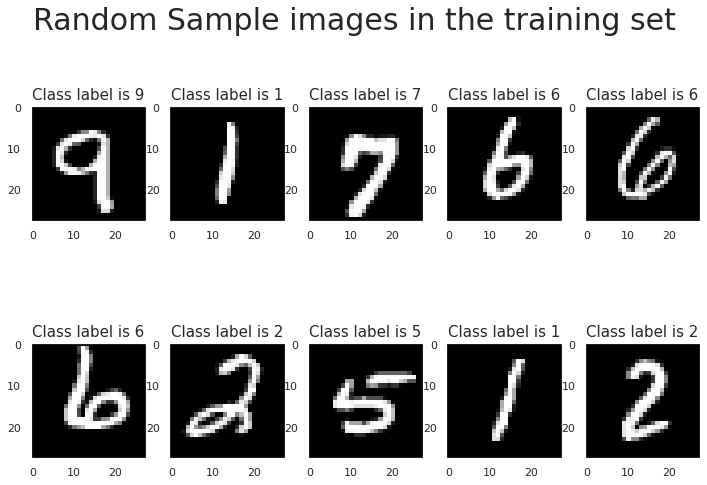

In [9]:
# Plot some random images from the training set along with their class labels
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Random Sample images in the training set', fontsize = 30)

# Generate random sample indices from the training set.
samp_index = np.random.randint(low = 0, high = X_train.shape[0], size = 10).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 5, (ind + 1))
    plt.imshow(X_train[value, :], cmap = 'gray')
    ax.set_title("Class label is %d" %(y_train[value]), fontsize = 15)
    ax.grid(False)

plt.show()

### Validation Set

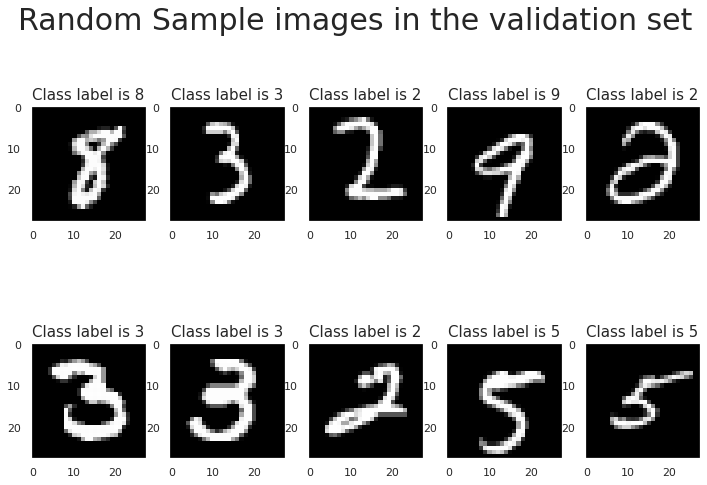

In [10]:
# Plot some random images from the validation set along with their class labels
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Random Sample images in the validation set', fontsize = 30)

# Generate random sample indices from the validation set.
samp_index = np.random.randint(low = 0, high = X_val.shape[0], size = 10).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 5, (ind + 1))
    plt.imshow(X_val[value, :], cmap = 'gray')
    ax.set_title("Class label is %d" %(y_val[value]), fontsize = 15)
    ax.grid(False)
    
plt.show()

### Test Set

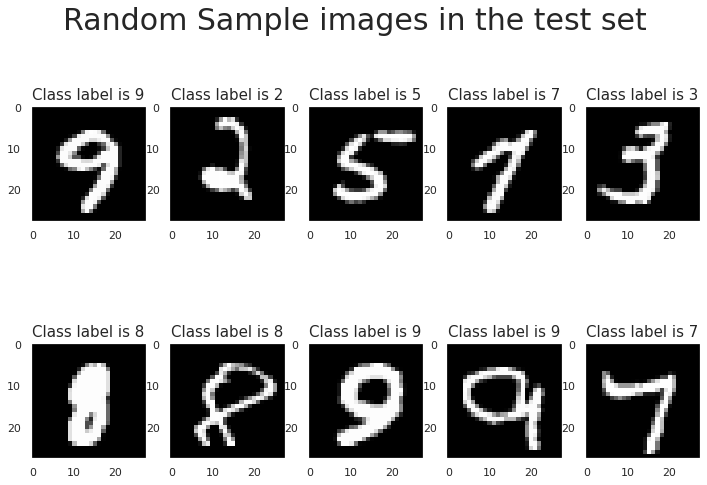

In [11]:
# Plot some random images from the test set along with their class labels
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Random Sample images in the test set', fontsize = 30)

# Generate random sample indices from the test set.
samp_index = np.random.randint(low = 0, high = X_test.shape[0], size = 10).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 5, (ind + 1))
    plt.imshow(X_test[value, :], cmap = 'gray')
    ax.set_title("Class label is %d" %(y_test[value]), fontsize = 15)
    ax.grid(False)
    
plt.show()

## One-hot encode training, validation and testing labels.

In [13]:
num_classes = 10 # Digits 0 to 9
y_train_ohe = to_categorical(y_train, num_classes = num_classes)
y_val_ohe = to_categorical(y_val, num_classes = num_classes)
y_test_ohe = to_categorical(y_test, num_classes = num_classes)
print("Shape of one-hot encoded training set output is {}" .format(y_train_ohe.shape))
print("Shape of one-hot encoded validation set output is {}" .format(y_val_ohe.shape))
print("Shape of one-hot encoded test set output is {}" .format(y_test_ohe.shape))

Shape of one-hot encoded training set output is (60000, 10)
Shape of one-hot encoded validation set output is (1000, 10)
Shape of one-hot encoded test set output is (9000, 10)


# Verify image transformations

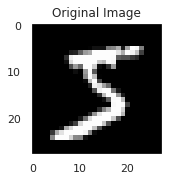

In [77]:
img = X_train[0]
img_w_ch_axis = np.expand_dims(img, axis = 2)

img_trans = [] # Empty list to store transformed images
img_trans.append(img_w_ch_axis)

rot = 90 # Clockwise rotation in degrees
wid_shift = 10 # Shift image 10 pixels to the left
hgt_shift = 10 # Shift image 10 pixels upwards

# Rotation only
img_trans.append(apply_affine_transform(img_w_ch_axis, theta = rot))
# Left Shift only
img_trans.append(apply_affine_transform(img_w_ch_axis, tx = wid_shift))
# Right Shift only
img_trans.append(apply_affine_transform(img_w_ch_axis, tx = -wid_shift))

#ty=0, shear=0, zx=1, zy=1, row_axis=0, col_axis=1,



plt.figure(figsize = (8, 8))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(np.squeeze(img_trans[0]), cmap = 'gray')
ax1.grid(b = False)
ax1.set_title("Original Image")

# ax2 = plt.subplot(1, 3, 2)
# ax2.imshow(img_rot[:, :, 0], cmap = 'gray')
# ax2.grid(b = False)
# ax2.set_title("Rotated Image")

# ax3 = plt.subplot(1, 3, 3)
# ax3.imshow(img_rot[:, :, 0], cmap = 'gray')
# ax3.grid(b = False)
# ax3.set_title("Rotated Image")

plt.show()


# Define Image Data Generators

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 0, shear_range = 0, zoom_range = 0,\
                                   channel_shift_range = 0.0, width_shift_range = 0.0,\
                                   height_shift_range = 0.0, horizontal_flip = False, rescale = 1./255)

## Preprocess data

In [ ]:
# Preprocess the data - Cast to 'float32' and scale by 255
X_train = (X_train.astype("float32")) / 255
X_val = (X_val.astype("float32")) / 255
X_test = (X_test.astype("float32")) / 255
y_train = y_train.astype("float32")
y_val = y_val.astype("float32")
y_test = y_test.astype("float32")

print("Shape of X_train is {}" .format(X_train.shape))
print("Shape of y_train is {}" .format(y_train.shape))
print("Shape of X_val is {}" .format(X_val.shape))
print("Shape of y_val is {}" .format(y_val.shape))
print("Shape of X_test is {}" .format(X_test.shape))
print("Shape of y_test is {}" .format(y_test.shape))
print()
print("Minimum value of X_train is %0.1f" %(np.min(X_train)))
print("Maximum value of X_train is %0.1f" %(np.max(X_train)))
print("Minimum value of X_val is %0.1f" %(np.min(X_val)))
print("Maximum value of X_val is %0.1f" %(np.max(X_val)))
print("Minimum value of X_test is %0.1f" %(np.min(X_test)))
print("Maximum value of X_test is %0.1f" %(np.max(X_test)))
print()
print("Data-type of X_train is {}" .format(X_train.dtype))
print("Data-type of X_val is {}" .format(X_val.dtype))
print("Data-type of X_test is {}" .format(X_test.dtype))
print("Data-type of y_train is {}" .format(y_train.dtype))
print("Data-type of y_val is {}" .format(y_val.dtype))
print("Data-type of y_test is {}" .format(y_test.dtype))

Shape of X_train is (51000, 28, 28)
Shape of y_train is (51000,)
Shape of X_val is (9000, 28, 28)
Shape of y_val is (9000,)
Shape of X_test is (10000, 28, 28)
Shape of y_test is (10000,)

Minimum value of X_train is 0.0
Maximum value of X_train is 1.0
Minimum value of X_val is 0.0
Maximum value of X_val is 1.0
Minimum value of X_test is 0.0
Maximum value of X_test is 1.0

Data-type of X_train is float32
Data-type of X_val is float32
Data-type of X_test is float32
Data-type of y_train is float32
Data-type of y_val is float32
Data-type of y_test is float32


In [ ]:
print("Unique values in y_train: {}" .format(np.unique(y_train)))
print("Unique values in y_val: {}" .format(np.unique(y_val)))
print("Unique values in y_test: {}" .format(np.unique(y_test)))

Unique values in y_train: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Unique values in y_val: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Unique values in y_test: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


<b>There are 10 unique class labels (0 to 9) in the training, validation and testing data.</b>

## Visualize the data

# Fully-Connected Models

## Model_1: SNN_3L

* Model_1 is a shallow network with three FC layers. It will have:
    1. A flatten layer
    2. Hidden layer - 1 (256 neurons and ReLU activation)
    3. Hidden layer - 2 (256 neurons and ReLU activation)
    4. Final dense layer with 10 neurons, a softmax activation function and L2 regularization.

### Function - Define Model Core

In [ ]:
def model_1_core(hidden_nodes = 256, output_nodes = 10, Lambda = 0):
    
    """
    Function to define the model core for 3-layer .
    
    Arguments:
    hidden_nodes - Number of nodes for the hidden layers
    output_nodes = Number of nodes in the output layer
    Lambda - L2 regularization parameter

    """    
    
    model_1 = models.Sequential() # Instantiate Sequential model
    model_1.add(layers.Input(shape=(28, 28), name = "INP_LAY")) # Add input layer
    model_1.add(layers.Flatten(name = "FLAT_LAY")) # Add Flatten layer
    model_1.add(layers.Dense(hidden_nodes, activation = 'relu',\
                             kernel_initializer = glorot_uniform(seed = 0),\
                             name = "HID_LAY_1")) # Add hidden layer - 1
    model_1.add(layers.Dense(hidden_nodes, activation = 'relu',\
                             kernel_initializer = glorot_uniform(seed = 0),\
                             name = "HID_LAY_2")) # Add hidden layer - 2
    model_1.add(layers.Dense(output_nodes, activation = 'softmax',\
                             kernel_initializer = glorot_uniform(seed = 0),\
                             kernel_regularizer = regularizers.l2(Lambda),\
                             name = "OUT_LAY")) # Add output layer
    
    return model_1

In [ ]:
# Verify model defined above
temp_model = model_1_core(256, 10, 0)
temp_model.summary()

### Function - Define model compile, train and eval

In [ ]:
def model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10, Lambda = 0,\
                         epochs = 5, lr = 0.01, verb = 1, tb_str = "Temp"):
    
    """
    Function to compile, fit and evaluate model_1.
    
    Arguments:
    hidden_nodes - Number of nodes for the hidden layers
    output_nodes = Number of nodes in the output layer
    Lambda - L2 regularization parameter
    epochs - Number of epochs to train for
    lr - Learning rate to use for training
    verb - Whether to print running summary during model fit or evaluate

    """      
    
    # Instantiate model
    model_1 = model_1_core(hidden_nodes, output_nodes, Lambda)
    
    # Optimizer = SGD with learning rate = lr.
    opt = optimizers.SGD(learning_rate = lr) 
    
    # Try out other optimizer options
    opt_1 = optimizers.SGD(learning_rate = lr, decay = 1e-6, momentum = 0.9) 

    # Loss = CategoricalCrossEntropy with default settings
    cce = tf.keras.losses.CategoricalCrossentropy() 
    # Metric = Categorical Accuracy
    met = tf.keras.metrics.CategoricalAccuracy()
    # Compile model
    model_1.compile(optimizer = opt_1, loss = cce, metrics = met)
    
    # Define path for tensorboard logs
    logdir = os.path.join(tb_logs_base_dir, tb_str) 
    # Define Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 0)
    
    # Fit model
    hist = model_1.fit(X_train, y_train_ohe, epochs = epochs, batch_size = 1000, verbose = verb,\
                       validation_split = 0.15, callbacks=[tensorboard_callback])
    
    # Evaluate model on test set
    score = model_1.evaluate(X_test, y_test_ohe, verbose = verb)  
    
    return score, model_1, hist

In [ ]:
# display(model_3.loss)
# display(model_3.optimizer.get_config())

### Launch Tensorboard

In [ ]:
#%tensorboard --logdir {tb_logs_base_dir}
#%tensorboard --logdir {tb_logs_base_dir}

### Coarse search for Lambda and lr

In [ ]:
# num_trials = 50 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 8)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Lambda', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-4.0, 1))
#   Lambda = np.power(10, np.random.uniform(-4.0, 2))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, _, hist = model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10,\
#                                         Lambda = Lambda, epochs = 100, lr = lr,\
#                                         verb = 0, tb_str = ("M1_VSGD_CS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = Lambda
#   res_arr[k, 2] = hist.history['loss'][-1]
#   res_arr[k, 3] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 4] = hist.history['val_loss'][-1]
#   res_arr[k, 5] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 6] = score[0]
#   res_arr[k, 7] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))
#   print()         
                                              
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M1_VSGD_CS.csv"), index = False)

In [ ]:
# m1_vsgd_cs_res_arr_df = pd.read_csv(out_base_path + "M1_VSGD_CS.csv")
# m1_vsgd_cs_res_arr_df.sort_values('Val_Loss')

<b>Review of coarse search results:</b>

1. Considering all results where validation accuracy is greater than 95% (15 out 50 results), 
  * Range of learning_rate is 1.5e-2 to 1.2. 
  * Range of Lambda is 1.6e-4 to 0.37.
2. Considering all results where validation loss is less than 0.25 (13 out of 50 results), 
  * Range of learning rate is 1.5e-2 to 0.5.
  * Range of Lambda is 1.6e-4 to 0.37
3. Based on this, lets do a fine search with:
  * Learning rate ranging from 1e-2 to 1.
  * Lambda ranging from 1e-4 to 1 



### Fine search for Lambda and lr

In [ ]:
# num_trials = 50 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 8)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Lambda', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-2.0, 0))
#   Lambda = np.power(10, np.random.uniform(-4.0, 0))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, _, hist = model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10,\
#                                         Lambda = Lambda, epochs = 100, lr = lr,\
#                                         verb = 0, tb_str = ("M1_VSGD_CS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = Lambda
#   res_arr[k, 2] = hist.history['loss'][-1]
#   res_arr[k, 3] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 4] = hist.history['val_loss'][-1]
#   res_arr[k, 5] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 6] = score[0]
#   res_arr[k, 7] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))
#   print()         
                                              
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M1_VSGD_FS.csv"), index = False)

In [ ]:
# m1_vsgd_fs_res_arr_df = pd.read_csv(out_base_path + "M1_VSGD_FS.csv")
# m1_vsgd_fs_res_arr_df.sort_values('Val_Loss')

<b>Review of fine search results:</b>

1. Taking the result with the best validation accuracy (98.23%) and the best training set accuracy (99.998%), let's now set the following values and re-train the model:
  * Learning rate = 0.46
  * Lambda = 1.5e-4



### Final training

In [ ]:
lr = 0.46 # Final learning rate
Lambda = 1.5e-4 # Final value of Lambda
print("Model fit started.... ", end = ', ')
tic = time.process_time() # Set clock timer
score, model_1, hist = model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10,\
                                            Lambda = Lambda, epochs = 100, lr = lr,\
                                            verb = 0, tb_str = ("M1_VSGD_FT"))
toc = time.process_time() # Stop clock timer        
print("Model Fit Completed.... Elapsed time = %0.2f seconds" %(toc - tic))

# Save final trained weights to file
model_1.save_weights(out_base_path + 'model_1_weights.h5') # Save weights in Keras HDF5 format
# Save training history to file
np.save((out_base_path + 'model_1_hist.npy'), hist.history)

### Plot learning curves

In [ ]:
# Load history files from disk
hist_model_1 = np.load((out_base_path + 'model_1_hist.npy'), allow_pickle = 'TRUE').item()

fig = plt.figure(figsize = (8, 6))
fig.suptitle("Learning Curve", fontsize = 30)
plt.plot(hist_model_1['loss'], 'r-', label = 'Training_Set_Loss')
plt.plot(hist_model_1['val_loss'], 'b-', label = 'Validation_Set_Loss')
plt.ylabel('Running Loss', fontsize = 20)
plt.xlabel('# Epochs', fontsize = 20)
plt.grid(b = True)
plt.legend(fontsize = 15)
#plt.tight_layout()
plt.show()

<b>Learning curves above show that the loss has settled down in 100 epochs. So, there is no need to train further.</b>

In [ ]:
print("Initial training set loss is %0.4f" %(hist_model_1['loss'][0]))
print("Initial training set accuracy is %0.4f %%" % (100 * (hist_model_1['categorical_accuracy'][0])))
print("Final training set loss is %0.4f" %(hist_model_1['loss'][-1]))
print("Final training set accuracy is %0.4f %%" % (100 * (hist_model_1['categorical_accuracy'][-1])))
print()
print("Initial validation set loss is %0.4f" %(hist_model_1['val_loss'][0]))
print("Initial validation set accuracy is %0.4f %%" % (100 * (hist_model_1['val_categorical_accuracy'][0])))
print("Final validation set loss is %0.4f" %(hist_model_1['val_loss'][-1]))
print("Final validation set accuracy is %0.4f %%" % (100 * (hist_model_1['val_categorical_accuracy'][-1])))


### Evaluate model on training and test sets

In [ ]:
# Evaluate model on training set
model_1.load_weights((out_base_path + 'model_1_weights.h5')) # Load weights
res = model_1.evaluate(X_train, y_train_ohe, batch_size = 100, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()

In [ ]:
# Evaluate model on test set
model_1.load_weights((out_base_path + 'model_1_weights.h5')) # Load mbgd weights
res = model_1.evaluate(X_test, y_test_ohe, batch_size = 100, verbose = 0, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()

### Summary of Model_1 so far

<b>1. Model Details</b>
  * Input size = (28 * 28) gray-scale image
  * Two hidden layers with 256 neurons each and ReLU activation.
  * One output layer with 10 neurons, softmax activation and L2-regularization
  * Total number of trainable parameters = 269, 322

<b>2. Final training parameters</b>
  * Glorot_uniform initialization for all three layers.
  * Vanilla SGD optimizer.
  * Learning Rate = 0.46
  * Lambda = 1.5e-4
  * Number of training set samples = 51000
  * Number of validation set samples = 9000
  * Number of test set samples = 10000

<b>3. Final performance after training</b>
  * Training set loss = 0.022
  * Training set accuracy = 99.72 %
  * Validation set loss = 0.084
  * Validation set accuracy = 98.13 %
  * Test set loss = 0.077
  * Test set accuracy = 97.98%

### Try out other training options

#### Coarse search for Lambda and lr

In [ ]:
# num_trials = 50 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 8)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Lambda', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-4.0, 1))
#   Lambda = np.power(10, np.random.uniform(-4.0, 2))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, model_1, hist = model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10,\
#                                         Lambda = Lambda, epochs = 100, lr = lr,\
#                                         verb = 0, tb_str = ("M1_VSGD_CS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = Lambda
#   res_arr[k, 2] = hist.history['loss'][-1]
#   res_arr[k, 3] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 4] = hist.history['val_loss'][-1]
#   res_arr[k, 5] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 6] = score[0]
#   res_arr[k, 7] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))
                                                
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M1_SGD_M0P9_D1EM6_CS.csv"), index = False)

#### Fine search for Lambda and lr

In [ ]:
# num_trials = 50 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 8)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Lambda', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-3.0, 0))
#   Lambda = np.power(10, np.random.uniform(-4.0, 0))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, _, hist = model_1_comp_tr_eval(hidden_nodes = 256, output_nodes = 10,\
#                                         Lambda = Lambda, epochs = 100, lr = lr,\
#                                         verb = 0, tb_str = ("M1_VSGD_CS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = Lambda
#   res_arr[k, 2] = hist.history['loss'][-1]
#   res_arr[k, 3] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 4] = hist.history['val_loss'][-1]
#   res_arr[k, 5] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 6] = score[0]
#   res_arr[k, 7] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))
                                              
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M1_SGD_M0P9_D1EM6_FS.csv"), index = False)

#### Summary of other options

<b>1. Model Details</b>
  * Model is same as earlier.

<b>2. Final training parameters</b>
  * Glorot_uniform initialization for all three layers.
  * SGD optimizer with decay rate = 1e-6 and momentum = 0.9
  * Learning Rate = 0.15
  * Lambda = 1.1e-3
  * Number of training set samples = 51000
  * Number of validation set samples = 9000
  * Number of test set samples = 10000

<b>3. Final performance after training</b>
  * Training set loss = 0.01
  * Training set accuracy = 100 %
  * Validation set loss = 0.076
  * Validation set accuracy = 98.35 %
  * Test set loss = 0.068
  * Test set accuracy = 98.15%

Overall, the performance with these new training options is slightly better than the vanilla SGD.

## Model_2: DNN_5L

* Model_2 is a deep network with five FC layers. It will have:
    1. A flatten layer
    2. Hidden layer - 1 (50 neurons and ReLU activation)
    3. Hidden layer - 2 (50 neurons and ReLU activation)
    4. Hidden layer - 3 (50 neurons and ReLU activation)
    5. Hidden layer - 4 (50 neurons and ReLU activation)
    4. Final dense layer with 10 neurons and a softmax activation function.

### Function - Define Model Core

In [ ]:
def model_2_core(hidden_nodes = 50, output_nodes = 10):
    
    """
    Function to define the model core for 5-layer deep NN .
    
    Arguments:
    hidden_nodes - Number of nodes for the hidden layers
    output_nodes = Number of nodes in the output layer

    """    
    
    model_2 = models.Sequential() # Instantiate Sequential model
    model_2.add(layers.Input(shape=(28, 28), name = "INP_LAY")) # Add input layer
    model_2.add(layers.Flatten(name = "FLAT_LAY")) # Add Flatten layer
    
    model_2.add(layers.Dense(hidden_nodes,\
                             kernel_initializer = HeNormal(seed = 0),\
                             name = "HID_LAY_1")) # Add hidden layer - 1
    model_2.add(layers.BatchNormalization(name = "BN_LAY_1")) # Add BatchNorm layer
    model_2.add(layers.Activation('relu')) # Add ReLU activation
    model_2.add(layers.Dropout(rate = 0.2, seed = 0, name = "DROP_1"))    

    model_2.add(layers.Dense(hidden_nodes,\
                             kernel_initializer = HeNormal(seed = 0),\
                             name = "HID_LAY_2")) # Add hidden layer - 2
    model_2.add(layers.BatchNormalization(name = "BN_LAY_2")) # Add BatchNorm layer
    model_2.add(layers.Activation('relu')) # Add ReLU activation 
    model_2.add(layers.Dropout(rate = 0.2, seed = 0, name = "DROP_2"))    

    model_2.add(layers.Dense(hidden_nodes,\
                             kernel_initializer = HeNormal(seed = 0),\
                             name = "HID_LAY_3")) # Add hidden layer - 3
    model_2.add(layers.BatchNormalization(name = "BN_LAY_3")) # Add BatchNorm layer                             
    model_2.add(layers.Activation('relu')) # Add ReLU activation 
    model_2.add(layers.Dropout(rate = 0.2, seed = 0, name = "DROP_3"))    

    model_2.add(layers.Dense(hidden_nodes,\
                             kernel_initializer = HeNormal(seed = 0),\
                             name = "HID_LAY_4")) # Add hidden layer - 4
    model_2.add(layers.BatchNormalization(name = "BN_LAY_4")) # Add BatchNorm layer                             
    model_2.add(layers.Activation('relu')) # Add ReLU activation
    model_2.add(layers.Dropout(rate = 0.2, seed = 0, name = "DROP_4"))    

    model_2.add(layers.Dense(output_nodes, activation = 'softmax',\
                             kernel_initializer = HeNormal(seed = 0),\
                             name = "OUT_LAY")) # Add output layer
    
    return model_2

In [ ]:
# Verify model defined above
temp_model = model_2_core(50, 10)
temp_model.summary()

### Function - Define model compile, train and eval

In [ ]:
def model_2_comp_tr_eval(hidden_nodes = 50, output_nodes = 10, epochs = 5,\
                         lr = 0.01, verb = 1, tb_str = "Temp"):
    
    """
    Function to compile, fit and evaluate model_2.
    
    Arguments:
    hidden_nodes - Number of nodes for the hidden layers
    output_nodes = Number of nodes in the output layer
    epochs - Number of epochs to train for
    lr - Learning rate to use for training
    verb - Whether to print running summary during model fit or evaluate

    """      
    
    # Instantiate model
    model_2 = model_2_core(hidden_nodes, output_nodes)
    
    # Optimizer = SGD with learning rate = lr.
    opt = optimizers.SGD(learning_rate = lr) 
    
    # Try out other optimizer options
    # opt_1 = optimizers.SGD(learning_rate = lr, decay = 1e-6, momentum = 0.9)
    opt_2 = optimizers.Adam(learning_rate = lr) 

    # Loss = CategoricalCrossEntropy with default settings
    cce = tf.keras.losses.CategoricalCrossentropy() 
    # Metric = Categorical Accuracy
    met = tf.keras.metrics.CategoricalAccuracy()
    # Compile model
    model_2.compile(optimizer = opt_2, loss = cce, metrics = met)
    
    # Define path for tensorboard logs
    logdir = os.path.join(tb_logs_base_dir, tb_str) 
    # Define Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 0)
    
    # Fit model
    hist = model_2.fit(X_train, y_train_ohe, epochs = epochs, batch_size = 1000, verbose = verb,\
                       validation_split = 0.15, callbacks=[tensorboard_callback])
    
    # Evaluate model on test set
    score = model_2.evaluate(X_test, y_test_ohe, verbose = verb)  
    
    return score, model_2, hist

In [ ]:
# display(model_2.loss)
# display(model_2.optimizer.get_config())
# display(model_2.summary())

### Coarse search for lr

In [ ]:
# num_trials = 25 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 7)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-4.0, 1))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, model_2, hist = model_2_comp_tr_eval(hidden_nodes = 50, output_nodes = 10,\
#                                         epochs = 100, lr = lr, verb = 0,\
#                                         tb_str = ("M2BNDR_ADAM_CS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = hist.history['loss'][-1]
#   res_arr[k, 2] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 3] = hist.history['val_loss'][-1]
#   res_arr[k, 4] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 5] = score[0]
#   res_arr[k, 6] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))        
                                              
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M2BNDR_ADAM_CS.csv"), index = False)

<b>Review of coarse search results:</b>

<b><u>Option_1: Plain M2 with vanilla SGD</u></b>

1. Considering all results where validation accuracy is greater than 95% (19 out 50 results), 
  * Range of learning_rate is 1.5e-2 to 0.9. 
  * Range of Lambda is 2.2e-4 to 94.
2. Considering all results where validation loss is less than 0.2 (20 out of 50 results), 
  * Range of learning rate is 1.5e-2 to 0.9.
  * Range of Lambda is 2.2e-4 to 94.
3. Based on this, lets do a fine search with:
  * Learning rate ranging from 1e-2 to 1.
  * Lambda ranging from 1e-4 to 1 

<b><u>Option_2: M2 + BNorm with Adam</u></b>

1. Considering all results where validation accuracy is greater than 97% (12 out 25 results), lets do a fine search with learning rate ranging from 1e-4 to 0.1

<b><u>Option_3: M2 + BNorm + Dropout with Adam</u></b>

1. Best validation accuracy is around 97.8 (which is similar to the results without Dropout). So, not running fine search.

### Fine search for Lambda and lr

In [ ]:
# num_trials = 25 # Number of random trials to execute
# res_arr = np.zeros((num_trials, 7)) # Initialize array to store results

# # Define column names to use when created Pandas dataframe.
# res_cols = ['LR', 'Tr_Loss', 'Tr_Acc', 'Val_Loss', 'Val_Acc', 'Test_Loss', 'Test_Acc']

# for k in range(num_trials):
#   lr = np.power(10, np.random.uniform(-4.0, -1))
#   print("Trial %d of %d started.... " %((k +1), num_trials), end = ', ')
#   tic = time.process_time() # Set clock timer
#   score, model_2, hist = model_2_comp_tr_eval(hidden_nodes = 50, output_nodes = 10,\
#                                         epochs = 100, lr = lr, verb = 0,\
#                                         tb_str = ("M2BNDR_ADAM_FS_" + str(k)))
#   res_arr[k, 0] = lr
#   res_arr[k, 1] = hist.history['loss'][-1]
#   res_arr[k, 2] = (100 * hist.history['categorical_accuracy'][-1])
#   res_arr[k, 3] = hist.history['val_loss'][-1]
#   res_arr[k, 4] = (100 * hist.history['val_categorical_accuracy'][-1])
#   res_arr[k, 5] = score[0]
#   res_arr[k, 6] = (100 * score[1])
#   toc = time.process_time() # Stop clock timer        
#   print("Completed.... Elapsed time = %0.2f seconds" %(toc - tic))        
                                              
# res_arr_df = pd.DataFrame(res_arr, columns = res_cols)   
# res_arr_df.to_csv((out_base_path + "M2BNDR_ADAM_FS.csv"), index = False)

### Summary of Model_2

<b><u>Option_1</u></b>

  1. <b>Model Details</b>

    * Input size = (28 * 28) gray-scale image.
    * Four hidden layers with 50 neurons each followed by ReLU activation.
    * One output layer with 10 neurons and softmax activation.
    * Total number of trainable parameters = 47,410.

  2. <b>Final training parameters</b>

    * He Normal initialization for all layers.
    * Vanilla SGD optimizer.
    * Learning Rate = 0.1
    * Number of training set samples = 51000
    * Number of validation set samples = 9000
    * Number of test set samples = 10000

  3. <b>Final performance after training</b>

    * Training set loss = 0.02
    * Training set accuracy = 99.63 %
    * Validation set loss = 0.113
    * Validation set accuracy = 97.29 %
    * Test set loss = 0.108
    * Test set accuracy = 97.14%

<b><u>Option_2</u></b>

  1. <b>Model Details</b>

    * Same as the model above except that batch-norm is added between each dense layer and the ReLU activation

  2. <b>Final training parameters</b>

    * He Normal initialization for all layers.
    * Adam optimizer with default settings.
    * Learning Rate = 0.013    
    * Number of training set samples = 51000
    * Number of validation set samples = 9000
    * Number of test set samples = 10000

  3. <b>Final performance after training</b>

    * Training set loss = 0.0002
    * Training set accuracy = 99.998 %
    * Validation set loss = 0.135
    * Validation set accuracy = 98.02 %
    * Test set loss = 0.137
    * Test set accuracy = 97.95%

<b><u>Option_3</u></b>

  1. <b>Model Details</b>

    * Same as the model in Option_2 but with drop-out added after each ReLU layer.

  2. <b>Final performance after training</b>

    * Performance is similar to Option_2 (model without dropout)
  

# CNN Models

## Reshape input for use with conv layers

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("Shape of training set data input is {}" .format(X_train.shape))
print("Shape of validation set data input is {}" .format(X_val.shape))
print("Shape of test set data input is {}" .format(X_test.shape))

Shape of training set data input is (51000, 28, 28, 1)
Shape of validation set data input is (9000, 28, 28, 1)
Shape of test set data input is (10000, 28, 28, 1)


## Model_3: CNN_1

* Input shape = (28 x 28 x 1)
* Layers:

    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (26 x 26 x 32). 
    * Activation = 'ReLU'
    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (24 x 24 x 32)
    * Activation = 'ReLU'
    * Flatten: Output shape = (18432 x 1)
    * Dense: Output shape = (128 x 1)
    * Activation = 'ReLU'
    * Dense: Output shape = (10 x 1)
    * Activation = 'Softmax'


### Function - Define Model Core

In [ ]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
      'use_bnorm' - Boolean: If true, use BatchNormalization layer after each hidden layer
      'use_dropout' - Boolean: If true, use dropout after activation of each hidden layer
      'dropout_rate' - Value of dropout rate to use.

    Returns:
    model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    use_bnorm = model_dict['use_bnorm']
    use_dropout = model_dict['use_dropout']
    dropout_rate = model_dict['dropout_rate']

    model = Sequential() # Instantiate Sequential model
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "valid",\
                     kernel_initializer = HeNormal(seed = 0), input_shape = (28, 28, 1), name = 'C1'))
    if (use_bnorm):
      model.add(BatchNormalization(axis = -1, name = 'B1'))
    model.add(Activation('relu', name = 'A1'))
    if (use_dropout):
      model.add(Dropout(rate = dropout_rate[0], name = 'DR1'))    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = "valid",\
                     kernel_initializer = HeNormal(seed = 0), name = 'C2'))
    if (use_bnorm):
      model.add(BatchNormalization(axis = -1, name = 'B2'))
    model.add(Activation('relu', name = 'A2'))
    if (use_dropout):
      model.add(Dropout(rate = dropout_rate[1], name = 'DR2'))    
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'M1'))
    if (use_dropout):
      model.add(Dropout(rate = dropout_rate[2], name = 'DR3'))
    model.add(Flatten(name = 'F1'))
    model.add(Dense(128, activation = 'relu', kernel_initializer = HeNormal(seed = 0),\
                    name = "D1")) # Add output layer
    model.add(Dense(10, activation = 'softmax', kernel_initializer = HeNormal(seed = 0),\
                    name = "OL")) # Add output layer
    return model

In [ ]:
# Verify model defined above
model_dict = {'use_bnorm': True,
              'use_dropout': True, 
              'dropout_rate': [0.2, 0.3, 0.4]
              }
temp_model = model_core(model_dict)
temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 26, 26, 32)        320       
_________________________________________________________________
B1 (BatchNormalization)      (None, 26, 26, 32)        128       
_________________________________________________________________
A1 (Activation)              (None, 26, 26, 32)        0         
_________________________________________________________________
DR1 (Dropout)                (None, 26, 26, 32)        0         
_________________________________________________________________
C2 (Conv2D)                  (None, 24, 24, 32)        9248      
_________________________________________________________________
B2 (BatchNormalization)      (None, 24, 24, 32)        128       
_________________________________________________________________
A2 (Activation)              (None, 24, 24, 32)        0

### Function - Define model compile, train and eval

In [ ]:
def model_comp_fit_eval(model_dict, train_dict):
    
    """
    Function to compile, fit and evaluate model.
    
    Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
               - See function model_core for more details
    train_dict - Dictionary with list of keys / values needed to compile and train the model
      'epochs': Number of epochs to train for
      'early_stop': Boolean: If True, implement early stop
      'bat_size': Batch size to use while doing model fit
      'ilr': Initial learning rate to use for learning rate decay scheduler
      'dr': Decay rate to use for learning rate decay scheduler
      'ds': Decay step to use for learning rate decay scheduler
      'verb': Boolean: If True, print running summary during model fit.
      'tb_path': Path to store Tensorboard callback information
      'bm_path': File name to use for storing best model checkpoint
      'fm_path': File name to use for storing final trained model
      'hi_path': File name to use for storing training history

    Returns:
    score - List containing evaluated loss and accuracy on test set
    model - Model instance with trained weights
    hist - Training history object 

    """      
    # Retrieve train_dict parameters
    epochs = train_dict['epochs'] # Number of epochs to train for
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    bat_size = train_dict['bat_size'] # Batch size to use while doing model fit
    ilr = train_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler
    dr = train_dict['dr'] # Decay rate to use for learning rate decay scheduler
    ds = train_dict['ds'] # Decay step to use for learning rate decay scheduler
    verb = train_dict['verb'] # Boolean: If True, print running summary during model fit.
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    bm_path = train_dict['bm_path'] # File name to use for storing best model checkpoint
    fm_path = train_dict['fm_path'] # File name to use for storing final trained model
    hi_path = train_dict['hi_path'] # File name to use for storing training history


    # Instantiate model
    model = model_core(model_dict)
    
    # Define learning rate decay schedule
    lr_sch = InverseTimeDecay(ilr, ds, dr)
    # Define Optimizer
    opt = optimizers.Adam(learning_rate = lr_sch) 
    # Define Loss = CategoricalCrossEntropy with default settings
    cce = losses.CategoricalCrossentropy() 
    # Define Metric = Categorical Accuracy
    met = metrics.CategoricalAccuracy()

    # Compile model
    model.compile(optimizer = opt, loss = cce, metrics = met)
    
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path, datetime.datetime.now().strftime("%d_%H_%M_%S"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = bm_path, monitor = "val_loss", save_best_only = True,\
                                   save_weights_only = False, mode = "min", save_freq = "epoch")

    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 30,\
                                           mode = "min", verbose = 1)

    # Define list of all callbacks
    callback_list = []
    if (early_stop):
      callback_list.append(earlystopping_callback)
    if (tb_path != 'None'):
      callback_list.append(tensorboard_callback)
    if (bm_path != 'None'):
      callback_list.append(mcp_callback)

    # Fit model
    hist = model.fit(X_train, y_train_ohe, epochs = epochs, batch_size = bat_size, verbose = verb,\
                     validation_data = (X_val, y_val_ohe), callbacks = callback_list)
        
    # Evaluate model on test set
    score = model.evaluate(X_test, y_test_ohe, batch_size = 1000, verbose = 0)  

    # Save final trained model to file
    if (fm_path != 'None'):
      # Save final trained model in Keras HDF5 format
      model.save(fm_path, overwrite = True, save_format = 'h5') 
    if (hi_path != 'None'):
      # Save training history to file
      np.save(hi_path, hist.history)
    
    return score, model, hist

### Launch Tensorboard

In [ ]:
#%tensorboard --logdir {tb_logs_base_dir}
#%tensorboard --logdir {tb_logs_base_dir}

### Set all model, compile and training parameters

In [ ]:
### Define file paths
# Prefix to use for naming files and paths
mod_file_pref = "M3D" 
# Tensorboard base path
tb_path = os.path.join(tb_logs_base_dir, mod_file_pref) 
# Path for storing final trained model
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
# Path for storing best model (model with lowest validation set loss)
bm_path = os.path.join(out_base_path, mod_file_pref + "_bestmodel.h5")
# Path for storing training history
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Define model_dict and train_dict
model_dict = {'use_bnorm': True,
              'use_dropout': False,
              'dropout_rate': [0.2, 0.2, 0.2]
              }
train_dict = {'epochs': 1000, # Number of epochs to train for
              'early_stop': True, # Boolean: If True, implement early stop
              'bat_size': 60, # Batch size to use while doing model fit
              'ilr': 0.001, # Initial learning rate to use for learning rate decay scheduler
              'dr': 1, # Decay rate to use for learning rate decay scheduler
              'ds': (850 * 25), # Decay step to use for learning rate decay scheduler
              'verb': 0, # Boolean: If True, print running summary during model fit.
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'bm_path': bm_path, # File name to use for storing best model checkpoint
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }

print(tb_path)
print(bm_path)
print(fm_path)
print(hi_path)

C:/User_Directories/logs/MNIST/M3D
Model_Info/M3D_bestmodel.h5
Model_Info/M3D_finalmodel.h5
Model_Info/M3D_hist.npy


In [ ]:
# Verify model instantiation, loss and compile options
train_dict_temp = {'epochs': 0, # Number of epochs to train for
              'early_stop': True, # Boolean: If True, implement early stop
              'bat_size': 60, # Batch size to use while doing model fit
              'ilr': 0.001, # Initial learning rate to use for learning rate decay scheduler
              'dr': 1, # Decay rate to use for learning rate decay scheduler
              'ds': (850 * 100), # Decay step to use for learning rate decay scheduler
              'verb': 0, # Boolean: If True, print running summary during model fit.
              'tb_path': 'None', # Path to store Tensorboard callback information
              'bm_path': 'None', # File name to use for storing best model checkpoint
              'fm_path': 'None', # File name to use for storing final trained model
              'hi_path': 'None', # File name to use for storing training history
              }

_, temp_model, _ = model_comp_fit_eval(model_dict, train_dict_temp)
display(temp_model.loss)
display(temp_model.optimizer.get_config())
display(temp_model.summary())

### Fit model 

In [ ]:
# Start model fit
print("Model Fit started.... ", end = ', ')
tic = time.process_time() # Set clock timer
score, model, hist = model_comp_fit_eval(model_dict, train_dict)
toc = time.process_time() # Stop clock timer        
print("Completed.... Elapsed time = %0.1f minutes" %((toc - tic)/60))

Model Fit started.... , Epoch 00052: early stopping
Completed.... Elapsed time = 3.5 minutes


### Plot learning curves

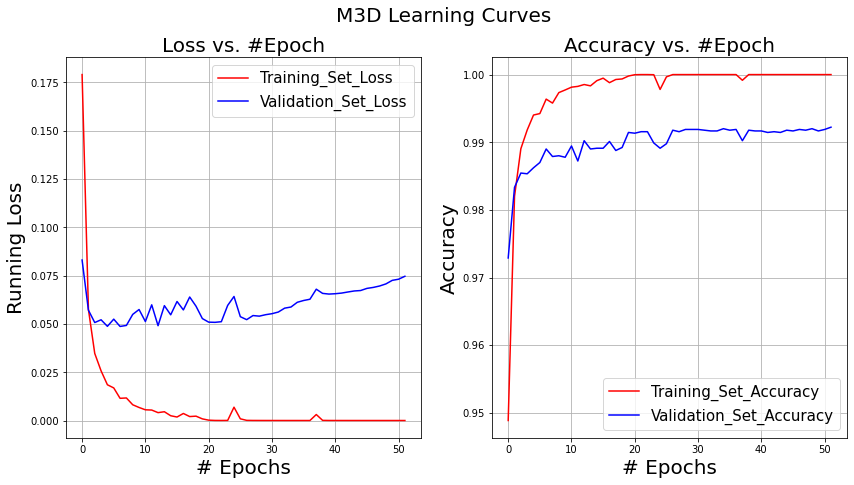

In [ ]:
# Load history files from disk
hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()

# Plot training and validation loss
fig = plt.figure(figsize = (14, 7))
fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(hist_model['loss'], 'r-', label = 'Training_Set_Loss')
ax1.plot(hist_model['val_loss'], 'b-', label = 'Validation_Set_Loss')
ax1.set_title("Loss vs. #Epoch", fontsize = 20)
ax1.set_ylabel('Running Loss', fontsize = 20)
ax1.set_xlabel('# Epochs', fontsize = 20)
ax1.grid(b = True)
ax1.legend(fontsize = 15)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(hist_model['categorical_accuracy'], 'r-', label = 'Training_Set_Accuracy')
ax2.plot(hist_model['val_categorical_accuracy'], 'b-', label = 'Validation_Set_Accuracy')
ax2.set_title("Accuracy vs. #Epoch", fontsize = 20)
ax2.set_ylabel('Accuracy', fontsize = 20)
ax2.set_xlabel('# Epochs', fontsize = 20)
ax2.grid(b = True)
ax2.legend(fontsize = 15)

#plt.tight_layout()
plt.show()

### Evaluate model on training and test sets

In [ ]:
### Evaluate model with final trained weights

# Load model with final trained weights
model = models.load_model(fm_path) 

# Evaluate model on training set
res = model.evaluate(X_train, y_train_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(X_val, y_val_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on test set
res = model.evaluate(X_test, y_test_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.0115
Training set accuracy is 99.88 %

Validation set loss is 0.0096
Validation set accuracy is 99.89 %

Test set loss is 0.0665
Test set accuracy is 99.12 %


In [ ]:
### Evaluate model with best weights (corresponding to lowest validation loss)
# Load model corresponding to lowest validation loss
model = models.load_model(bm_path)

# Evaluate model on training set
res = model.evaluate(X_train, y_train_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(X_val, y_val_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on test set
res = model.evaluate(X_test, y_test_ohe, batch_size = 1000, verbose = 0, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

Training set loss is 0.0080
Training set accuracy is 99.71 %

Validation set loss is 0.0487
Validation set accuracy is 98.90 %

Test set loss is 0.0472
Test set accuracy is 98.72 %


### Visualize intermediate outputs

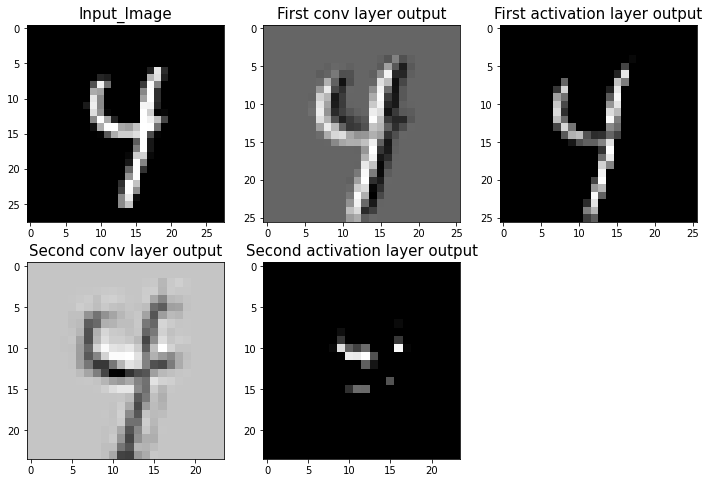

In [ ]:
# Load M3A model
mod_file_pref = "M3B" 
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5")
model = models.load_model(fm_path) 

c1 = model.layers[0] # Extract first conv layer (without activation)
a1 = model.layers[1] # Extract first ReLU activation layer
c2 = model.layers[2] # Extract second conv layer (without activation)
a2 = model.layers[3] # Extract second ReLU activation layer

ind = 20 # Define sample index to evaluate
fil1 = 5 # Define filter of first conv layer to evaluate
fil2 = 7 # Define filter of second conv layer to evaluate

# Define input and outputs of first four layers of model
X = X_train[ind:(ind+1), :, :, :]
X1 = c1(X)
X2 = a1(X1)
X3 = c2(X2)
X4 = a2(X3)

fig = plt.figure(figsize = (12, 8))

ax1 = plt.subplot(2, 3, 1)
ax1.set_title("Input_Image", fontsize = 15)
ax1.imshow(X[0, :, :, 0], cmap = 'gray')

ax2 = plt.subplot(2, 3, 2)
ax2.set_title("First conv layer output", fontsize = 15)
ax2.imshow(X1[0, :, :, fil1], cmap = 'gray')

ax3 = plt.subplot(2, 3, 3)
ax3.set_title("First activation layer output", fontsize = 15)
ax3.imshow(X2[0, :, :, fil1], cmap = 'gray')

ax4 = plt.subplot(2, 3, 4)
ax4.set_title("Second conv layer output", fontsize = 15)
ax4.imshow(X3[0, :, :, fil2], cmap = 'gray')

ax5 = plt.subplot(2, 3, 5)
ax5.set_title("Second activation layer output", fontsize = 15)
ax5.imshow(X4[0, :, :, fil2], cmap = 'gray')

plt.show()

### Confusion matrix

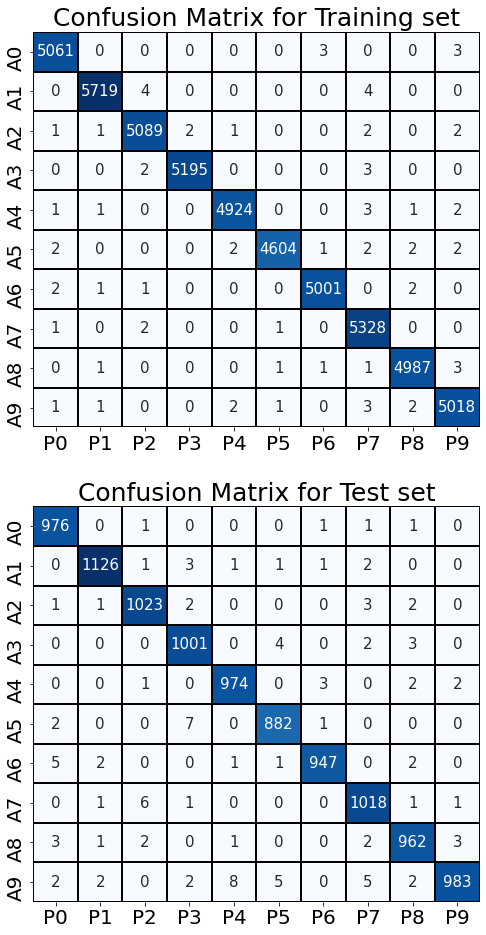

In [ ]:
# Obtain predicted labels for training and testing sets
y_train_pred = model.predict(X_train, batch_size = 1000) # Generate predictions for training set
y_test_pred = model.predict(X_test, batch_size = 1000) # Generate predictions for test set
y_train_pred = np.argmax(y_train_pred, axis = 1) # Convert probabilities to label
y_test_pred = np.argmax(y_test_pred, axis = 1) # Convert probabilities to label

# Generate confusion matrices
cm_train = tf.math.confusion_matrix(y_train, y_train_pred).numpy()
cm_test = tf.math.confusion_matrix(y_test, y_test_pred).numpy()

# Convert confusion matrices to pandas DF
index = [('A' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
columns = [('P' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
cm_train_df = pd.DataFrame(cm_train, index = index, columns = columns)
cm_test_df = pd.DataFrame(cm_test, index = index, columns = columns)

# Plot confusion matrices
fig = plt.figure(figsize = (8, 16))

ax1 = plt.subplot(2, 1, 1)
sns.heatmap(cm_train_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
            linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
            cbar = False, ax = ax1)
ax1.set_title("Confusion Matrix for Training set", fontsize = 25)
ax1.tick_params(labelsize = 20)

ax2 = plt.subplot(2, 1, 2)
sns.heatmap(cm_test_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
            linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
            cbar = False, ax = ax2)
ax2.set_title("Confusion Matrix for Test set", fontsize = 25)
ax2.tick_params(labelsize = 20)
plt.show() 

### Make Predictions

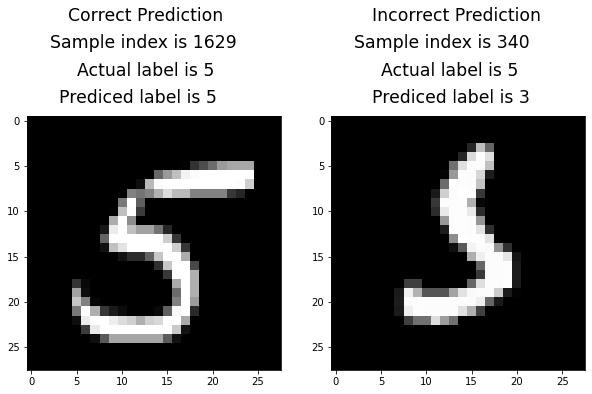

In [ ]:
# Make predictions on the test set for a given label
label = 5 # Actual label for which prediction will be done
act_ind = np.nonzero(y_test == label)[0] # Indices in test set corresponding to above label

# Obtain indices corresponding to correct and incorrect predictions for the given label
incorr_pred_ind = act_ind[np.nonzero(y_test_pred[act_ind] != label)[0]]
corr_pred_ind = np.setdiff1d(act_ind, incorr_pred_ind)

fig = plt.figure(figsize = (10, 5))

# Example of a correct prediction
ax1 = plt.subplot(1, 2, 1)
ind = np.random.choice(corr_pred_ind, 1) # Choose a random index from corr_pred_ind
X = X_test[ind[0], :, :, 0]
plt.imshow(X, cmap = 'gray');
temp = plt.text(4, -11, 'Correct Prediction', fontsize = 'xx-large')
temp = plt.text(2, -8, 'Sample index is %d' % ind[0], fontsize = 'xx-large')
temp = plt.text(5, -5, 'Actual label is %d' % y_test[ind[0]], fontsize = 'xx-large')
temp = plt.text(3, -2, 'Prediced label is %d' % y_test_pred[ind[0]], fontsize = 'xx-large')

# Example of an incorrect prediction
ax2 = plt.subplot(1, 2, 2)
ind = np.random.choice(incorr_pred_ind, 1) # Choose a random index from incorr_pred_ind
X = X_test[ind[0], :, :, 0]
plt.imshow(X, cmap = 'gray');
temp = plt.text(4, -11, 'Incorrect Prediction', fontsize = 'xx-large')
temp = plt.text(2, -8, 'Sample index is %d' % ind[0], fontsize = 'xx-large')
temp = plt.text(5, -5, 'Actual label is %d' % y_test[ind[0]], fontsize = 'xx-large')
temp = plt.text(4, -2, 'Prediced label is %d' % y_test_pred[ind[0]], fontsize = 'xx-large')